# 실험 결과

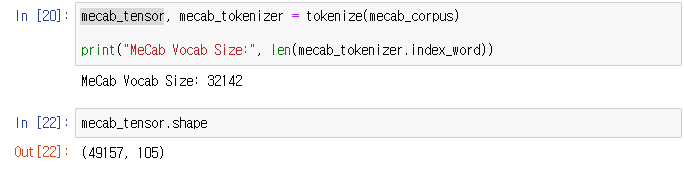

- 전처리를 거치지않은 Mecab은 32142 보카사이즈
- 그리고 토크나이즈 이후 최대 길이는 105 였다


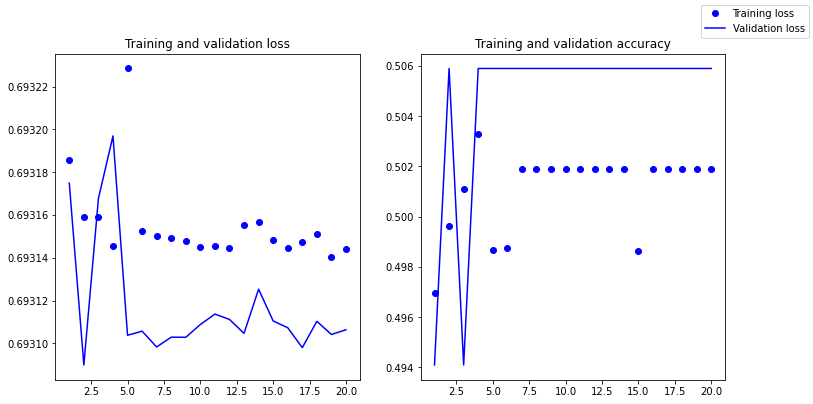

In [1]:
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:


# 데이터를 읽어봅시다. 

traindata_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_train.txt'
testdata_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_test.txt'

train_data = pd.read_table(traindata_path)
test_data = pd.read_table(testdata_path)

train_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 중복 결측치 제거

In [3]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

In [4]:
raw_cop = list(train_data['document'])
train_label = train_data['label']

In [5]:
def preprocess_sentence(sentence):
    # 온점 사이에 공백을 넣기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 연속 공백을 하나의 공백으로 변환
#     sentence = re.sub(r'[" "]+', " ", sentence)
    # 큰따옴표를 제거
#     sentence = re.sub(r'["]', '', sentence)
    # 완성되지 않은 표현을 제거 (ㅜㅜ 또는 ㅇㅇ 같은 느낌)
    sentence = re.sub(r"[^가-힣a-zA-Z.?!]+", "", sentence)
    # 양쪽 공백을 제거
    sentence = sentence.strip()
    return sentence

In [6]:
max_len = 50
min_len = 10

# cleaned_corpus = preprocess_sentence(raw_cop)

# 길이 조건에 맞는 문장만 선택합니다.
filtered_df = train_data[train_data['document'].apply(lambda x: min_len <= len(x) < max_len)]

filtered_df['document'] = filtered_df['document'].apply(preprocess_sentence)
# filtered_corpus = [preprocess_sentence(s) for s in raw_cop if (len(s) < max_len) & (len(s) >= min_len)]

/tmp/ipykernel_1888/3846040970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['document'] = filtered_df['document'].apply(preprocess_sentence)


In [7]:
len(train_data)

49157

In [8]:
len(filtered_df)

36619

In [9]:
filtered_corpus = list(filtered_df['document'])
train_label = filtered_df['label']

In [10]:
filtered_corpus[0]

'GDNTOPCLASSINTHECLUB'

In [11]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 377122 Oct 10 08:36 korean_spm.model
-rw-r--r-- 1 root root 146682 Oct 10 08:36 korean_spm.vocab


In [12]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [13]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

tensor, word_index, index_word = sp_tokenize(s,filtered_corpus)

In [14]:
# validation set 20000건 분리
X_val = tensor[:10000]   
y_val = train_label[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = tensor[10000:]
partial_y_train = train_label[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(26619, 39)
(26619,)


In [15]:
vocab_size = len(index_word) # 어휘 사전의 크기입니다 - word_to_index의 길이 load_data 보면 설정해줬음 10000개로
word_vector_dim = 16   # 학습시키면서 진행할테니 - 일단 16차원으로 적어둔다

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 모니터링
    patience=5,          # 검증 손실이 개선되지 않으면 3 epoch 후에 훈련 중단
    restore_best_weights=True  # 최적의 가중치를 복원
)

In [17]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                     callbacks=[early_stopping])

Epoch 1/20
52/52 [==============================] - 5s 14ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5077
Epoch 2/20
52/52 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.5077
Epoch 3/20
52/52 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6927 - val_accuracy: 0.5078
Epoch 4/20
52/52 [==============================] - 0s 6ms/step - loss: 0.6150 - accuracy: 0.6969 - val_loss: 0.5301 - val_accuracy: 0.7565
Epoch 5/20
52/52 [==============================] - 0s 6ms/step - loss: 0.4345 - accuracy: 0.8263 - val_loss: 0.4707 - val_accuracy: 0.7934
Epoch 6/20
52/52 [==============================] - 0s 6ms/step - loss: 0.3477 - accuracy: 0.8709 - val_loss: 0.4642 - val_accuracy: 0.8022
Epoch 7/20
52/52 [==============================] - 0s 6ms/step - loss: 0.2967 - accuracy: 0.8979 - val_loss: 0.4750 - val_accuracy: 0.8044
Epoch 8/20
52/52 [=

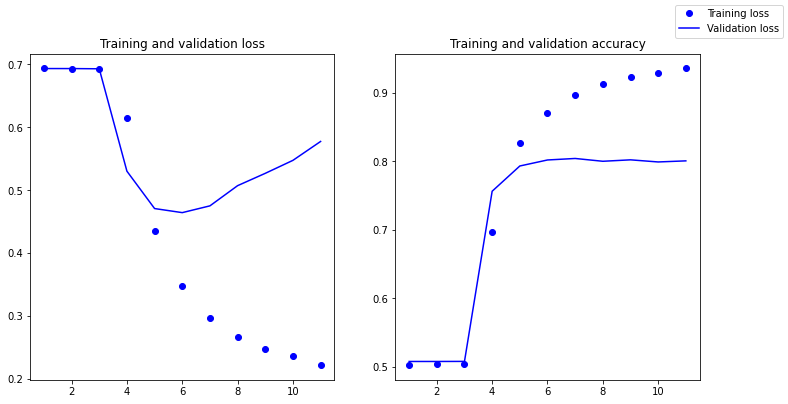

In [18]:
history_dict3 = history3.history


import matplotlib.pyplot as plt


acc3 = history_dict3['accuracy']

val_acc3 = history_dict3['val_accuracy']


loss3 = history_dict3['loss']


val_loss3 = history_dict3['val_loss']

epochs = range(1, len(acc3) + 1)

fig, axs = plt.subplots(1,2, figsize = (12,6))

axs[0].plot(epochs, loss3, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss3, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')

axs[1].plot(epochs, acc3, 'bo')
axs[1].plot(epochs, val_acc3, 'b')
axs[1].set_title('Training and validation accuracy')



fig.legend()